# Проект Банки
 - Презентация - https://drive.google.com/file/d/1nvcfvwApDNr1eipnbbJFBqikgbqiDrh_/view?usp=sharing
 - Дашборд - (https://public.tableau.com/app/profile/olga2053/viz/__16542713996060/Dashboard1?publish=yes)

# Описание проекта

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Проанализируйте клиентов регионального банка и сегментируйте пользователей по количеству потребляемых продуктов.

## Изучение общей информации. Предобработка данных.

### Загрузка и изучение данных 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats as st
from statsmodels.stats import weightstats as stests

Загрузим данные и изучим общую информацию

In [3]:
bank=pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Данные состоят из 12-ти столбцов и 10000 строк, типы данных приемлемые, названия столбцов следует привести к единому стилю.

### Приведем данные к нужным типам, виду

In [4]:
bank.columns = bank.columns.str.lower()
bank = bank.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Определим и изучим пропущенные значения

In [5]:
bank.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

В столбце c балансом находится 3617 пропущенных значений

In [6]:
round((bank.isna().mean()*100),2)

user_id              0.00
score                0.00
city                 0.00
gender               0.00
age                  0.00
objects              0.00
balance             36.17
products             0.00
credit_card          0.00
loyalty              0.00
estimated_salary     0.00
churn                0.00
dtype: float64

### Проверить данные на дубликаты

In [7]:
bank.duplicated().sum()

0

Явных дубликатов нет

## Проведение исследовательского анализа данных(EDA)

### Общее представление о клиенте, который пользуется продуктами банка 

Изучим распределение пользователей по городам:

In [8]:
bank['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

Больше всего пользователей приходится на Ярославль, примерно одинаковая картина по Ростову великому и Рыбинску. Посмотрим на распределение по полу

In [9]:
bank['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

Среди пользователей преобладают мужчины

<div class="alert alert-success"> 
    
Можно проверить гипотезу, что доля мужчин действительно больше. 
    
<div>

In [10]:
bank['age'].value_counts().head(20)

37    478
38    477
35    474
36    456
34    447
33    442
40    432
39    423
32    418
31    404
41    366
29    348
30    327
42    321
43    297
28    273
44    257
45    229
46    226
27    209
Name: age, dtype: int64

Самый частый возраст клиентов от 31 до 37 лет

In [11]:
bank['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

У большинства клиентов 1 продукт, чуть отстают по количеству клиенты с двумя продуктами

In [12]:
bank['credit_card'].value_counts()

1    7055
0    2945
Name: credit_card, dtype: int64

У 70% клиентов есть кредитная карта

In [13]:
bank['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

Чуть больше половины клиентов активны.

In [14]:
bank['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

20% клиентов попали в отток. Удалим столбец 'user_id', так как не содержит информации о признаках. Посмотрим на распределение количественных переменных.

In [15]:
bank = bank.drop(columns=['user_id'])
bank.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


 - максимальный балл кредитного скоринга  -  850  условных единиц, минимальный - 350. Медианаи равна 650, среднее - 652, стандартное отклонение - 97;
 - максимальный возраст - 92 года, минимальный - 18 лет. Медиана равна 37, среднее - 39, стандартное отклонение - 10;
 - максимальное количество объектов в собственности - 10, минимальное - 0. Медиана 5, среднее - 5, стандартное отклонение -3;
 - максимальный баланс на счете - 250898 у.е., минимальный - 3768, медиана 119839, среднее 119827, стандартное отклонение -30000у.е.;
 - максимальное количество используемых продуктов - 4, минимальное - 0. Медиана - 1, среднее 1,5,стандартное отклонение -0,6;
 - максимальная заработная плата - 199992 у.е., минимальная - 11.58, медиана - 100193, среднее - 100090,стандартное отклонение - 57510;

Для наглядности общего представления о клиенте отрисуем графики по каждому признаку. Сначала выделим количественные признаки и для них отрисуем графики

In [16]:
bank_num = ['score', 'age', 'balance', 'estimated_salary']

def create_hist_num(bank_num):
    for i in bank_num:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        
        sns.distplot(bank[i], bins=6,  kde=False, color='orange')
        #Зададим заголовок
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.show() 

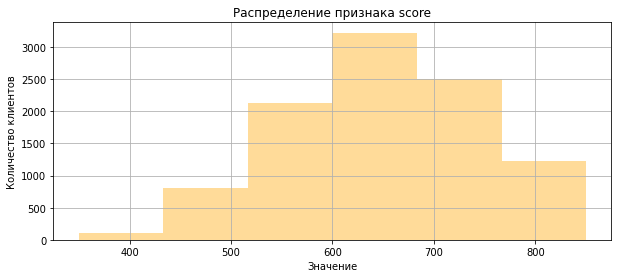

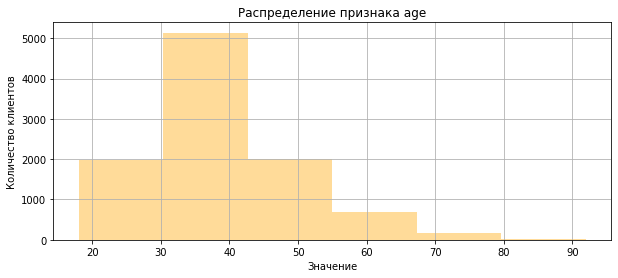

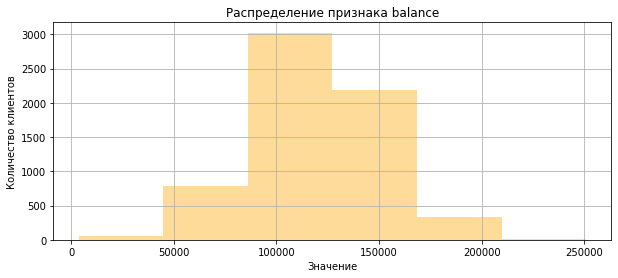

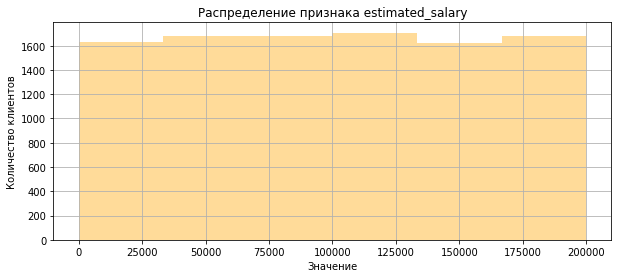

In [17]:
create_hist_num(bank_num)

Распределение данных в столбцах со скорингом, возрастом и балансом похоже на нормальное, расределение данных в столбце заработная плата - равномерное.</div>

То же самое проделаем доля категориальных переменных:

In [18]:
bank_ctg = ['city', 'gender', 'credit_card', 'loyalty', 'objects', 'products', 'churn']

def create_hist_ctg(bank_ctg):
    for i in bank_ctg:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        
        sns.countplot(bank[i], palette = "OrRd_r")
        #Зададим заголовок
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.show()  

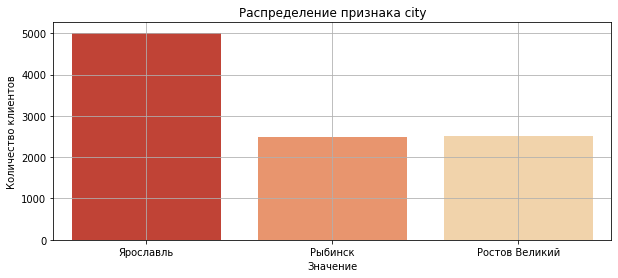

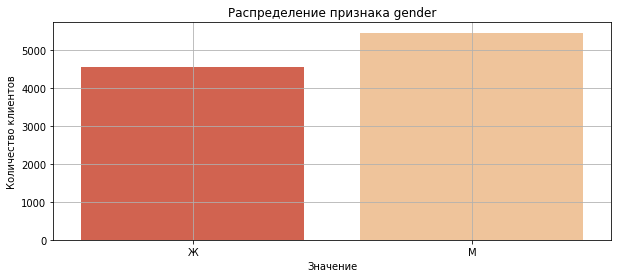

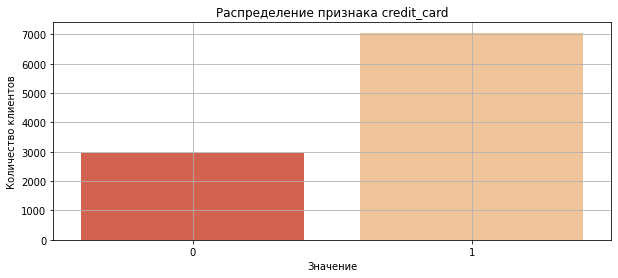

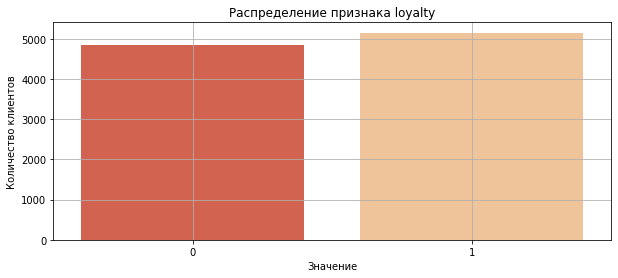

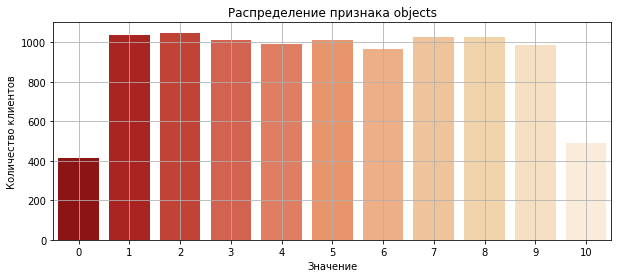

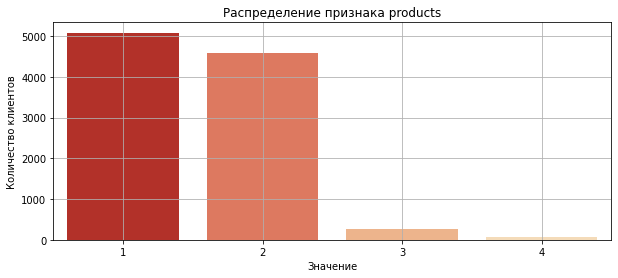

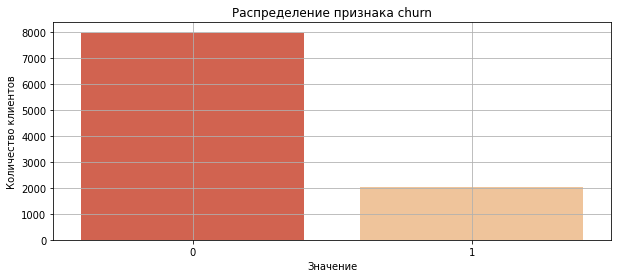

In [19]:
create_hist_ctg(bank_ctg)

Среди трех гордов сильно выделяется Ярославль, Рыбинск и Роств Великий примерно на одном уровне, доля мужчин среди пользователей выше, чем доля женщин, количество пльзователей, имеющих кредитную карту существенно выше, чем тех, у кого кредитной карты нет, параметр активности среи климентов делитя примерно одинаково, но число активных клиентов все-таки чуточку выше, количество объетов пользователей варьируется от 0 до 10, меньше всего пользователей без объетов и с 10тью объектами, остальное количество объектв распределено равномерно среди ользователей,  больше всего ользоватеей с одним продкутом, немного меньше с двумя, кдиентов с 3-4мя продуктами очень мало, пятая часть клиентов по каки-то причинам ушла из банка</div>

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [20]:
bank.groupby('churn').agg('mean')

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,
0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


Из сравнения средних значений видно, что:
Средние баллы кредитного скоринга для тех, кто ушел и тех, кто остался практически одинаковые, в отток ушло больше возрастных клиентов, количество объектов в собственности, как и количество средств на балансе не влияет на отток, среди дердателей кредитных карт больше тех, кто остался, в отток ушли малоактивные клиенты, но с заработной платой немного выше.


### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Построим гистограммы для количественных признаков

In [21]:
def create_hist_num_churn(bank_num):
    for i in bank_num:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        
        sns.distplot(bank.query('churn == 1')[i], bins=6,  kde=False, color='r',label='ушли')
        sns.distplot(bank.query('churn == 0')[i], bins=6,  kde=False, color='y',label='остались')
        #Зададим заголовок
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.legend() 
        plt.show() 

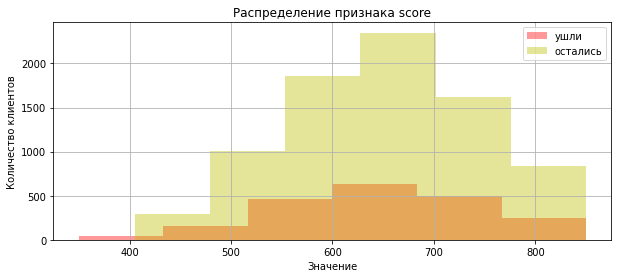

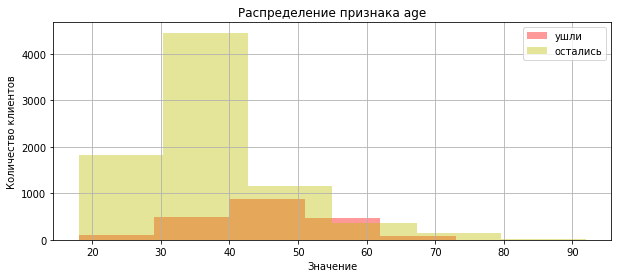

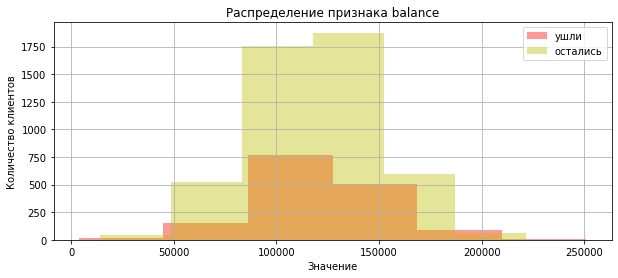

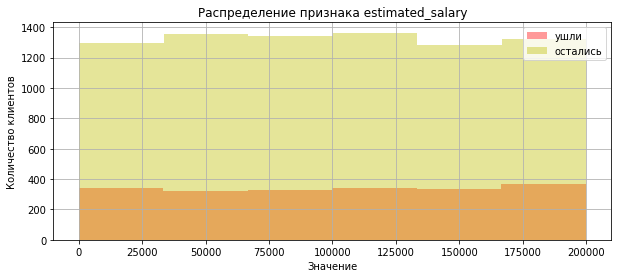

In [22]:
create_hist_num_churn(bank_num)

Среди ушедших клиентов преобладают те, у которых кредитный скоринг 600-680 балов, возраст 40-50, баланс на счете ниже среднего.

То же самое проделаем для категориальных признаков

In [23]:
bank_ctg_churn = ['city', 'gender', 'credit_card', 'loyalty']
def create_hist_ctg_churn(bank_ctg_churn):
    for i in bank_ctg_churn:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        sns.countplot(data=bank, x=i, hue='churn',  palette="bwr_r")
        #Зададим заголовок
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.legend(labels=['Остались', 'Ушли'])
        plt.show()  

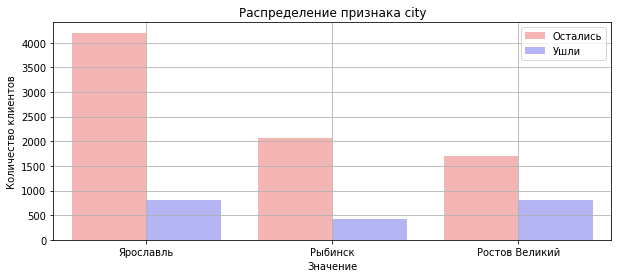

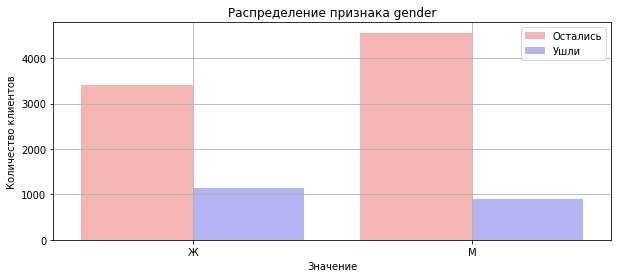

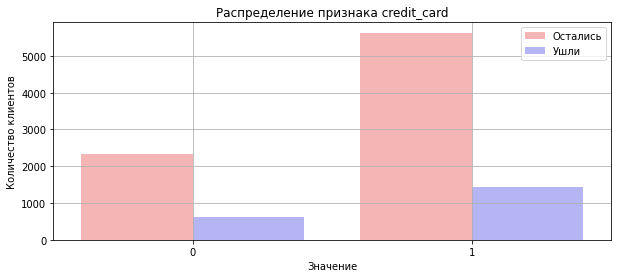

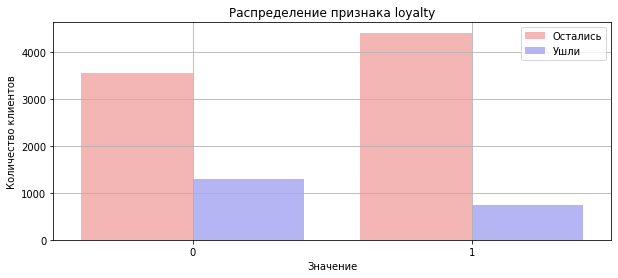

In [24]:
create_hist_ctg_churn(bank_ctg_churn)

Среди ушедших клинетов натраживают клиенты из Ростова великого, ушли столько же, сколко и в Ярославле, среди женщин отток выше, неактиынвные клиенты уходят чаще.

### Построим матрицу корреляций и отобразим её

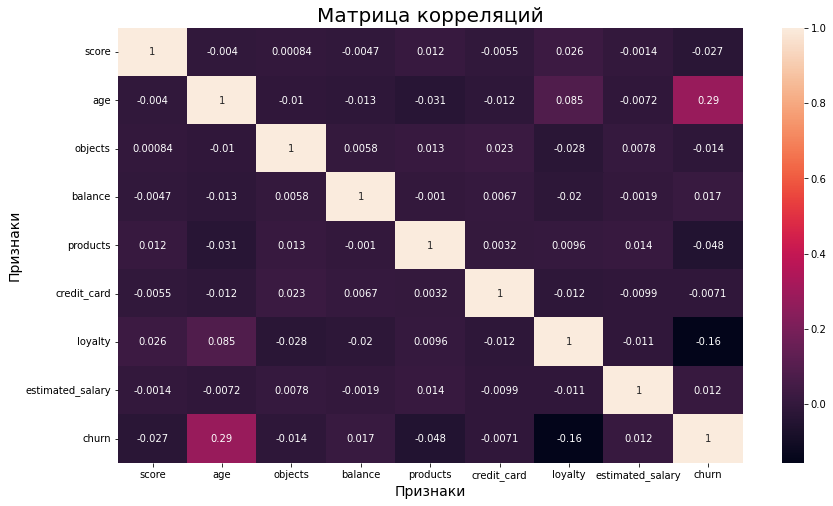

In [25]:
bank_corr = bank.corr()
plt.figure(figsize=(14,8))
sns.heatmap(bank_corr, annot = True, square=False)
plt.title('Матрица корреляций', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

Из матрицы видна слабая корреляции между возрастом и оттоком. Разобьем данные по городам и посмотрим зависимость признаков для каждого города.

In [26]:
bank_yaroslavl = bank.query("city == 'Ярославль'")
bank_yaroslavl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             5014 non-null   int64  
 1   city              5014 non-null   object 
 2   gender            5014 non-null   object 
 3   age               5014 non-null   int64  
 4   objects           5014 non-null   int64  
 5   balance           2596 non-null   float64
 6   products          5014 non-null   int64  
 7   credit_card       5014 non-null   int64  
 8   loyalty           5014 non-null   int64  
 9   estimated_salary  5014 non-null   float64
 10  churn             5014 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 470.1+ KB


In [27]:
bank_yaroslavl.head()

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
2,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
8,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0


In [28]:
bank_yaroslavl.isna().sum()

score                  0
city                   0
gender                 0
age                    0
objects                0
balance             2418
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

у 50% клиентов Ярославля по каким-то причинам не заполнена графа "Баланс", что составляет 67% от всех пропущенных значений

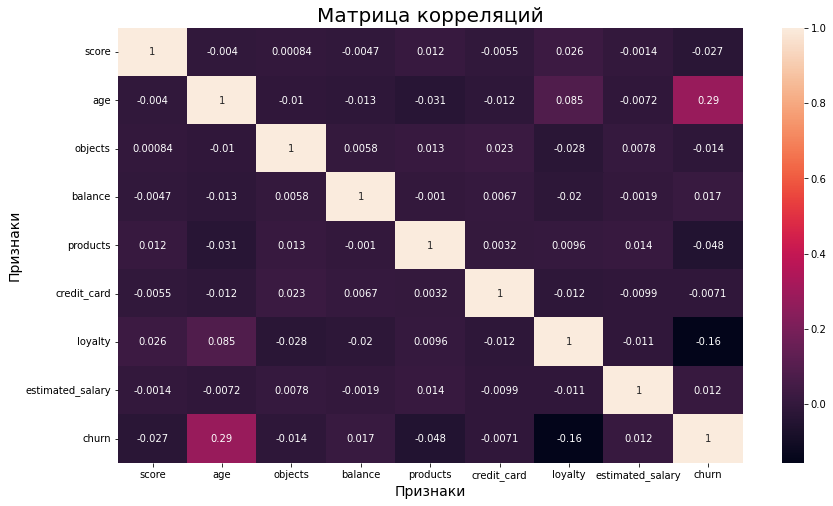

In [29]:
bank_yaroslavl_corr = bank_yaroslavl.corr()
plt.figure(figsize=(14,8))
sns.heatmap(bank_corr, annot = True, square=False)
plt.title('Матрица корреляций', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

Матрица корреляции по городу Ярославль идентична общей матрице

In [30]:
bank_rostov = bank.query("city == 'Ростов Великий'")
bank_rostov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             2509 non-null   int64  
 1   city              2509 non-null   object 
 2   gender            2509 non-null   object 
 3   age               2509 non-null   int64  
 4   objects           2509 non-null   int64  
 5   balance           2509 non-null   float64
 6   products          2509 non-null   int64  
 7   credit_card       2509 non-null   int64  
 8   loyalty           2509 non-null   int64  
 9   estimated_salary  2509 non-null   float64
 10  churn             2509 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 235.2+ KB


In [31]:
bank_rostov.head()

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
7,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
15,616,Ростов Великий,М,45,3,143129.41,2,0,1,64327.26,0
16,653,Ростов Великий,М,58,1,132602.88,1,1,0,5097.67,1
26,756,Ростов Великий,М,36,2,136815.64,1,1,1,170041.95,0
28,574,Ростов Великий,Ж,43,3,141349.43,1,1,1,100187.43,0


In [32]:
bank_rostov.isna().sum()

score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
credit_card         0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

Ростов Великий самый "порядочный" в плане пропусков - ни одного пропущенного значения!. Посмотрим матрицу корреляции

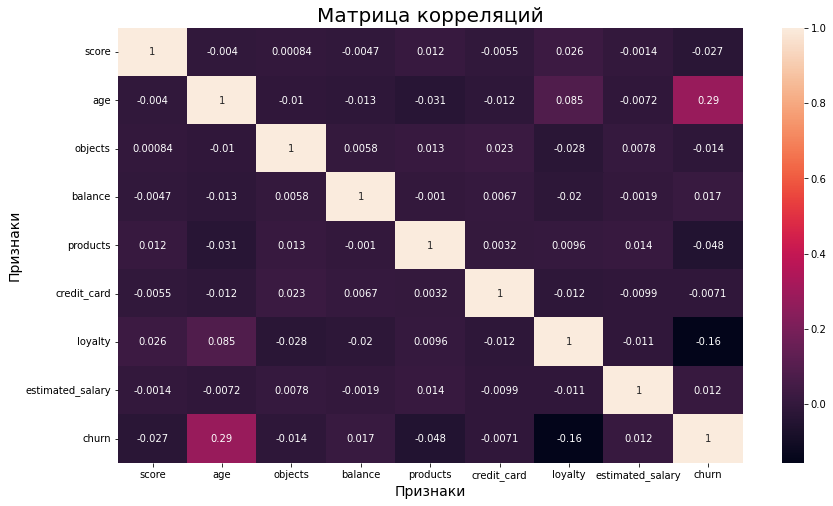

In [33]:
bank_rostov_corr = bank_rostov.corr()
plt.figure(figsize=(14,8))
sns.heatmap(bank_corr, annot = True, square=False)
plt.title('Матрица корреляций', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

Матрица корреляций новых связей не показала

In [34]:
bank_rybinsk = bank.query("city == 'Рыбинск'")
bank_rybinsk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 9992
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             2477 non-null   int64  
 1   city              2477 non-null   object 
 2   gender            2477 non-null   object 
 3   age               2477 non-null   int64  
 4   objects           2477 non-null   int64  
 5   balance           1278 non-null   float64
 6   products          2477 non-null   int64  
 7   credit_card       2477 non-null   int64  
 8   loyalty           2477 non-null   int64  
 9   estimated_salary  2477 non-null   float64
 10  churn             2477 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 232.2+ KB


In [35]:
bank_rybinsk.head(5)

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
1,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
4,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
11,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
14,635,Рыбинск,Ж,35,7,NaN,2,1,1,65951.65,0


In [36]:
bank_rybinsk.isna().sum()

score                  0
city                   0
gender                 0
age                    0
objects                0
balance             1199
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

В рыбинске так же, как и в Ярославле у половины пользователей не заполнена графа Баланс

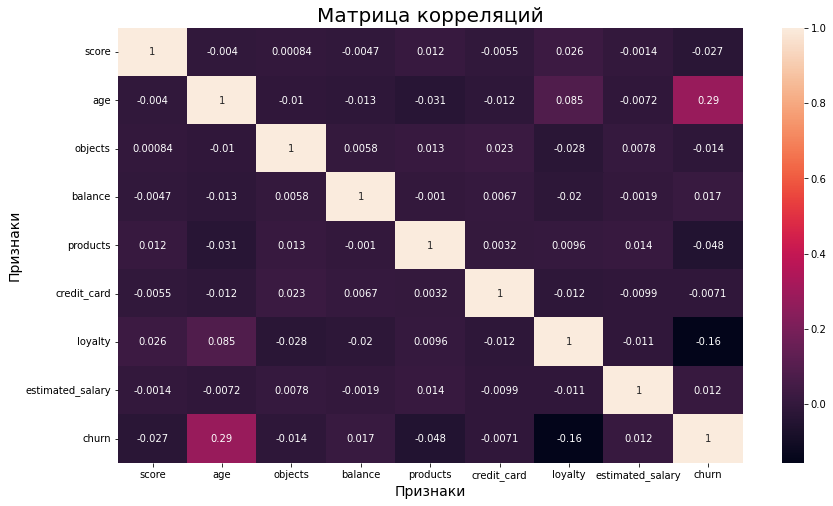

In [37]:
bank_rybinsk_corr = bank_rybinsk.corr()
plt.figure(figsize=(14,8))
sns.heatmap(bank_corr, annot = True, square=False)
plt.title('Матрица корреляций', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

По Рыбинску всу те же связи. Проверим результаты ,закодировав категориальные переменные город и пол методом one-hot encoding и построив матрицу корреляции. 

In [38]:
bank_cod = pd.get_dummies(bank, columns=['gender','city'])
bank_cod

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,619,42,2,NaN,1,1,1,101348.88,1,1,0,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0,1
3,699,39,1,NaN,2,0,0,93826.63,0,1,0,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,NaN,2,1,0,96270.64,0,0,1,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,1,0,0,1
9997,709,36,7,NaN,1,0,1,42085.58,1,1,0,0,0,1
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,1,0,0


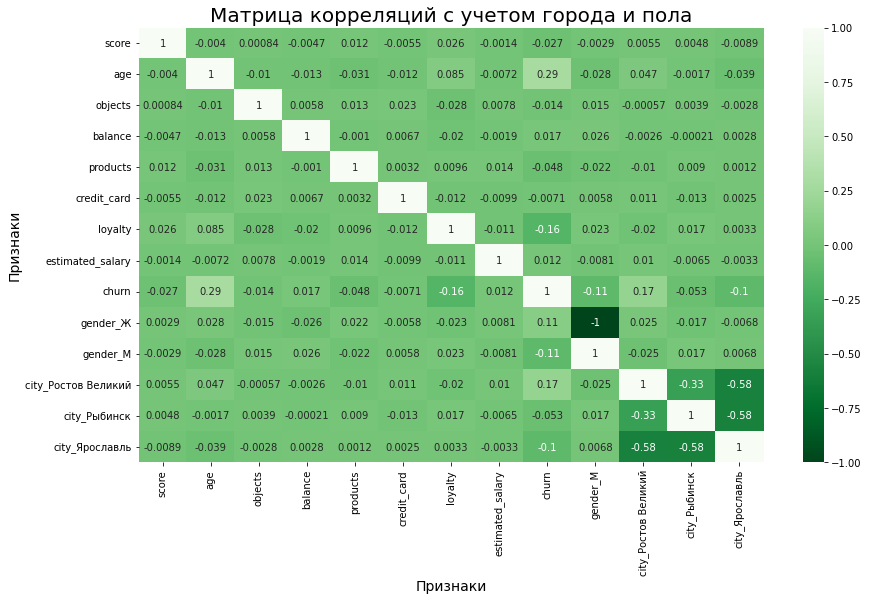

In [39]:
bank_cod_corr = bank_cod.corr()
bank_cod_corr = bank_cod_corr.drop(columns='gender_Ж')
plt.figure(figsize=(14,8))
sns.heatmap(bank_cod_corr, annot = True, square=False, cmap="Greens_r")
plt.title('Матрица корреляций c учетом города и пола', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

Помимо связи оттока с возрастом, появились новые слабые связи - с лояльностью(0,16), полом Ж(0,11), городом Ростов великий(0.17) и городом Ярославль(-0.1).
По остальным признакам корреляция не наблюдается.

## Сегментация клиентов на основе данных о количестве потребляемых продуктов

In [40]:
bank_cod.groupby('products').mean()

,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
products,,,,,,,,,,,,,
1,649.120968,39.673092,4.974626,119894.163723,0.703777,0.504131,99487.256851,0.277144,0.451613,0.548387,0.265342,0.240165,0.494493
2,652.188671,37.753595,5.051852,119660.944362,0.707190,0.532898,100452.012821,0.075817,0.448802,0.551198,0.226580,0.257734,0.515686
3,648.105263,43.195489,5.003759,119475.686310,0.714286,0.424812,104318.130564,0.827068,0.560150,0.439850,0.360902,0.248120,0.390977
4,653.583333,45.683333,5.300000,122260.610870,0.683333,0.483333,104763.723333,1.000000,0.633333,0.366667,0.400000,0.116667,0.483333


Самый большой отток среди клиентов, пользующихся 4мя продуктами, достаточно высокий отток среди клиентов с 3мя продуктами, практически оттока нет среди клиентов с двумя продуктами, и низкий отток среди клиентов с одним продуктом.

In [41]:
def create_hist_num_segm(bank_num):
    for i in bank_num:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        
        sns.distplot(bank.query('0< products<2')[i], kde=False, color="y", bins = 6)
        sns.distplot(bank.query('products==2')[i], kde=False, color="red", bins = 6)
        sns.distplot(bank.query('2< products<5')[i], kde=False, color="green", bins = 6)
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.legend(labels=['1 продукт', '2 продукта', '3-4 продукта'])
        plt.show() 

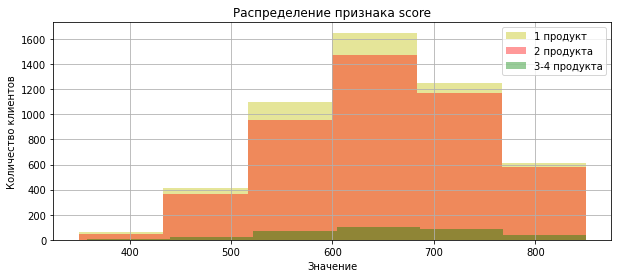

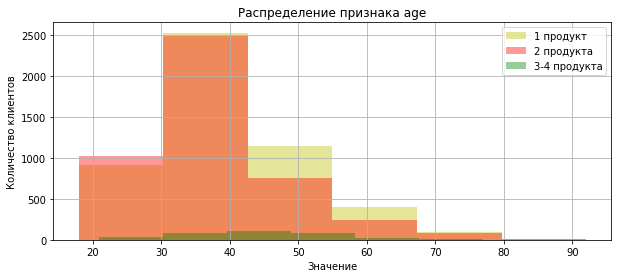

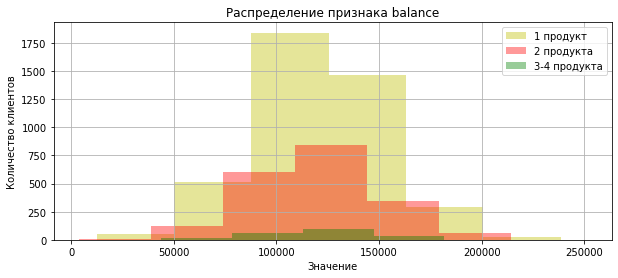

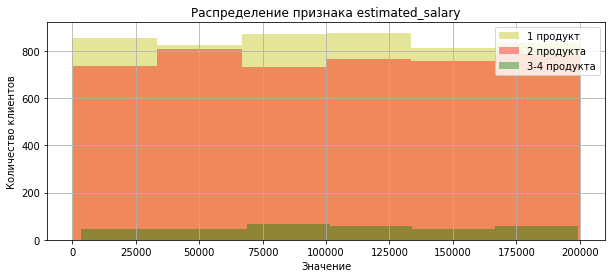

In [42]:
create_hist_num_segm(bank_num)

Баллы скоринга для всех групп примерно одинаковые (650). Клиенты с 1-2 продуктами моложе(30-40), чем клиенты с 3-4 продуктами. Много незаполненных данных о балансе у клиентов с 2-3 продуктами. Заработная плата у всех групп не сильнро отличается

In [43]:
def create_hist_ctg_churn(bank_ctg_churn):
    for i in bank_ctg_churn:
        #Построим гистограмму. Зададим размер
        plt.figure(figsize =(10, 4))
        #Строим график
        sns.countplot(data=bank, x=i, hue='products',  palette="bwr_r")
        #Зададим заголовок
        plt.title('Распределение признака {}'.format(i))
        #Подишем ось x
        plt.xlabel('Значение')
        #Подпишем ось y
        plt.ylabel('Количество клиентов')
        plt.grid()
        plt.legend(labels=['1 продукт', '2 продукта', '3 продукта', '4 продукта'])
        plt.show()  

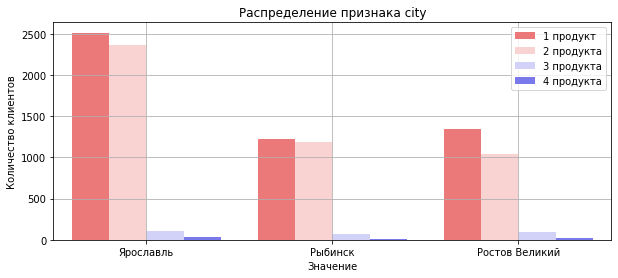

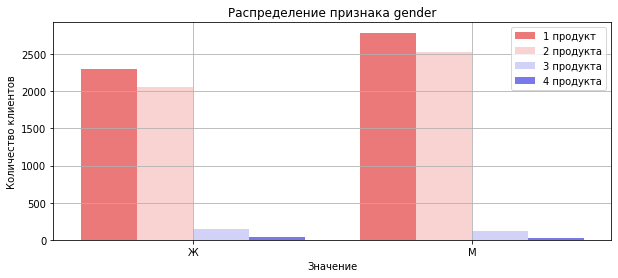

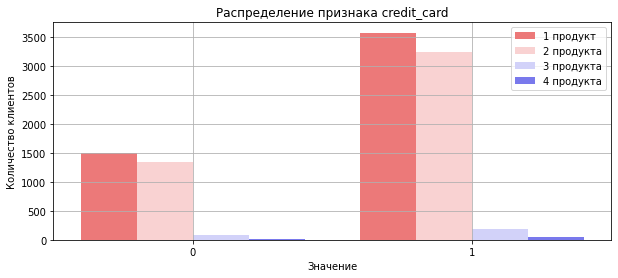

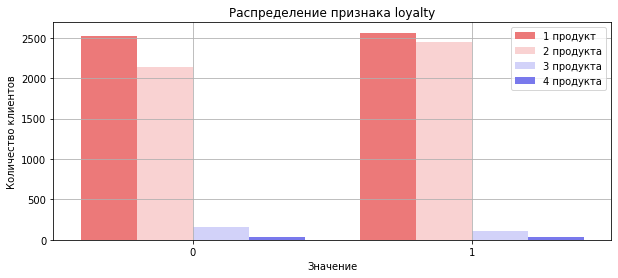

In [44]:
create_hist_ctg_churn(bank_ctg_churn)

Клиентов с 3-4 продуктами существенно меньше, чем клиентов, пользующихся одним или двумя продуктами. Большая часть клиентов находится в Ярославле и количество клиентов с 1 продуктом немного преолбладает над количеством клиентов с 2мя продуктами. Мужчин больше, чем женщин, и у мужчин и у женщин в приоритете 1 банковский продукт.У большинства клиентов есть кредитные карты,у клиентов с 1 продкутом этот показатель немного выше , чем с 2мя. Средаи активных клиентов примерно равное число тех, у кого 1 и 2 продукта. 

### Кластеризация клиентов

Выполним стандартизацию данных

In [45]:
bank_cod = bank_cod.dropna()
bank_cod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6383 entries, 1 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   score                6383 non-null   int64  
 1   age                  6383 non-null   int64  
 2   objects              6383 non-null   int64  
 3   balance              6383 non-null   float64
 4   products             6383 non-null   int64  
 5   credit_card          6383 non-null   int64  
 6   loyalty              6383 non-null   int64  
 7   estimated_salary     6383 non-null   float64
 8   churn                6383 non-null   int64  
 9   gender_Ж             6383 non-null   uint8  
 10  gender_М             6383 non-null   uint8  
 11  city_Ростов Великий  6383 non-null   uint8  
 12  city_Рыбинск         6383 non-null   uint8  
 13  city_Ярославль       6383 non-null   uint8  
dtypes: float64(2), int64(7), uint8(5)
memory usage: 529.8 KB


In [46]:
sc = StandardScaler()
X_sc = sc.fit_transform(bank_cod)

запустим функцию linkage() и отрисуем дентограмму

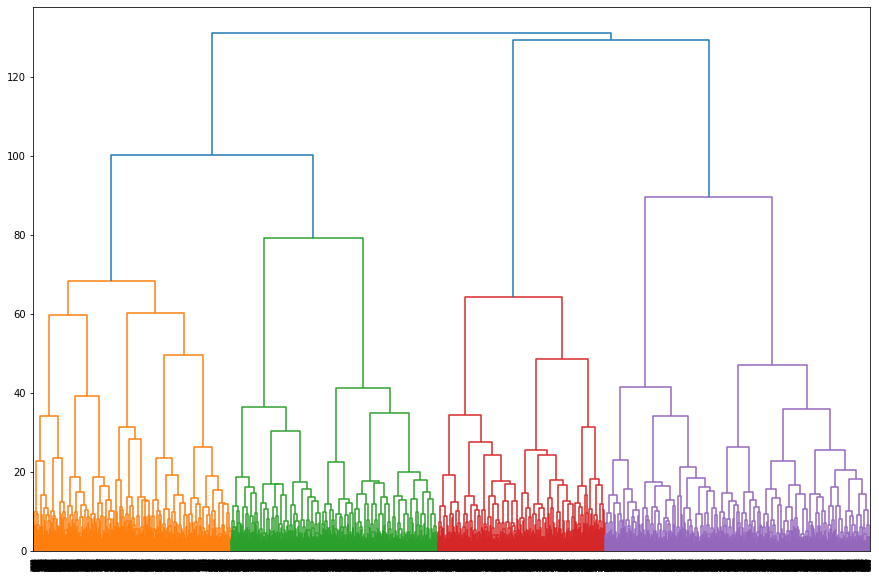

In [47]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Обучим модель кластеризации на основании алгоритма K-Means, число кластеров  n=4, Добавим столбец с кластерами в исходную таблицу и посмотрим на количество клиентов в каждом кластере

In [48]:
km = KMeans(n_clusters = 4, random_state=0)
labels = km.fit_predict(X_sc)
bank_cod['cluster_km'] = labels

bank_cod.groupby('cluster_km')['score'].agg('count')

cluster_km
0    1444
1    2345
2    1316
3    1278
Name: score, dtype: int64

Средние значения признаков для кластеров

In [49]:
bank_cod.groupby('cluster_km').agg('mean')

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
cluster_km,,,,,,,,,,,,,,
0,652.229917,38.546399,5.016620,121151.608213,1.268006,0.701524,0.514543,101302.689751,0.145429,0.000000,1.000000,0.000000,0.0,1.000000
1,651.197441,39.436674,4.915565,118776.415876,1.424733,0.696375,0.489126,101134.366712,0.303198,1.000000,0.000000,0.508742,0.0,0.491258
2,649.966565,39.424772,5.050152,120259.668222,1.527356,0.720365,0.523556,99905.033959,0.278116,0.000000,1.000000,1.000000,0.0,0.000000
3,651.003912,39.261346,4.982786,119814.985923,1.302817,0.679969,0.546948,100127.281135,0.195618,0.425665,0.574335,0.000000,1.0,0.000000


Выделяются 4 кластера:
     - Кластер 0 - Мужчины со средним возрастом 38,5 из Ярославля, с количеством объектов 5, преимущественно пользователи одного продукта, срдней активности, с заработной платой выше среднего, с самым низким оттоком;
    - Кластер 1 - Женщины со средним возрастом 39,4 года из Ярославля и РОстова Великого, пользователи 1-2 продуктов, самый неактивные из всех кластеров,  заработно йплатой выше среднего, с самым высоким оттоком;
     - Кластер 2 - Мужчины со средним возрастом 39,4 из Ростова Великого, пользователи 1-2 продуктов, с активностью выше среднего, заработной платой  ниже среднего, со средним оттоком;
     - Клатер 3 - Пользователи 39 лет из Рыбинска, преимущетвенно пользователи 1 ого прдукта, самые активные из всех кластеров со средней зараьотной плаой, отток низкий

## Формулирование и проверка статистических гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

Сформулируем нулевую(H0) и альтернативную(H1) гипотезу:
 - Доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, равны(H0);
 - Доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, различаются(H1).
Пороговое значение alpha примем за 5%.

Посмотрим на распределения доходов в двух группах и на основании этого распределения выберем подходящий метод оценки.

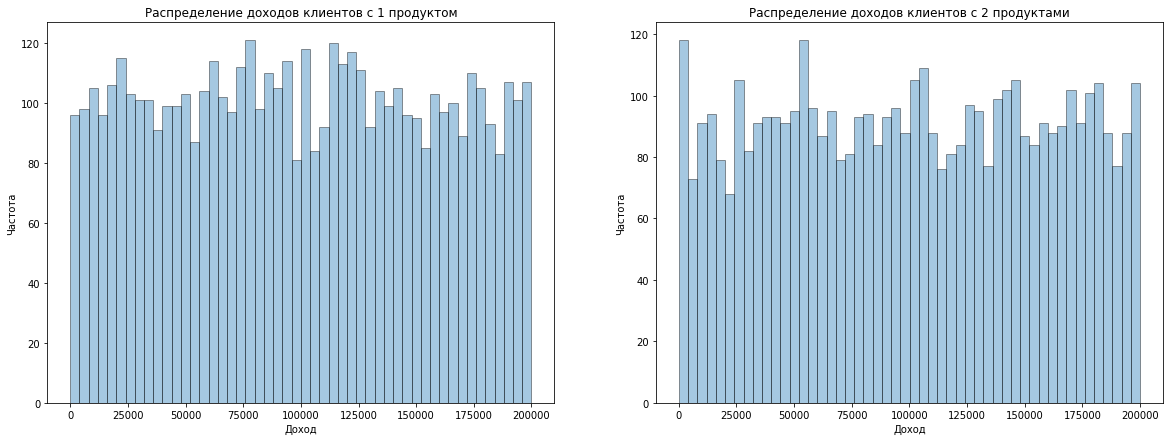

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))

sns.distplot(bank.query('products == 1')['estimated_salary'], kde=False, hist=True, 
             bins=50, hist_kws={'edgecolor':'black'}, ax=ax1)
ax1.set_title("Распределение доходов клиентов c 1 продуктом")
ax1.set_ylabel('Частота')
ax1.set_xlabel('Доход')

sns.distplot(bank.query('products == 2')['estimated_salary'], kde=False, hist=True, 
             bins=50, hist_kws={'edgecolor':'black'}, ax=ax2)
ax2.set_title("Распределение доходов клиентов с 2 продуктами")
ax2.set_ylabel('Частота')
ax2.set_xlabel('Доход')

plt.show()

Так как у нас распределение равномерное,  будем применять метод Манна—Уитни. 

In [51]:
alpha = 0.05

results = st.mannwhitneyu(bank.query('products == 1')['estimated_salary'], bank.query('products == 2')['estimated_salary'], 
          alternative = 'two-sided')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4079566651927651
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу: доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, не различаются.

### Гипотеза различия оттока между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

Сформулируем нулевую(H0) и альтернативную(H1) гипотезу:
 - Отток клиентов, которые пользуются двумя продуктами банка, и отток тех, которые пользуются одним, равны(H0);
 - Отток клиентов, которые пользуются двумя продуктами банка, и отток тех, которые пользуются одним, различаются(H1).
Пороговое значение alpha примем за 5%.

<div class="alert alert-info"> Доля ушедших клиентов, которые пользуются двумя продуктами банка, и доля ушедших клиентов, которые пользуются одним, равны(H0);
Доля ушедших клиентов, которые пользуются двумя продуктами банка, и доля ушедших клиентов, которые пользуются одним, различаются(H1). </b>  

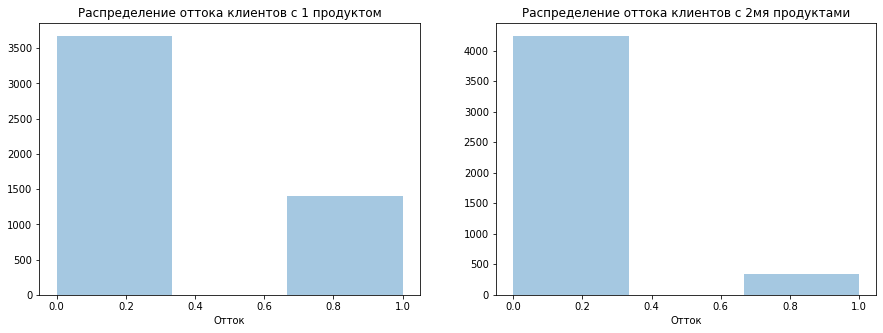

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
  
sns.distplot(bank.query('products == 1')['churn'], kde=False, ax=ax1, bins = 3)
ax1.set_title("Распределение оттока клиентов c 1 продуктом")
ax1.set_xlabel('Отток')

sns.distplot(bank.query('products == 2')['churn'], kde=False, ax=ax2, bins = 3)
ax2.set_title("Распределение оттока клиентов с 2мя продуктами")
ax2.set_xlabel('Отток')

plt.show()

Распределение не нормальное, поскольку переменная churn моежет принимать только 2 значения(0 и 1), будем использовать Z-критерий для сравнения долей.

In [53]:
alpha = 0.05

results, pvalue = stests.ztest(
    bank.query('products == 1')['churn'], x2=bank.query('products == 2')['churn'],
    value = 0, alternative='two-sided')

print('p-значение:', pvalue)

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7671628312943217e-155
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу: отток клиентов, которые пользуются двумя продуктами, и отток тех, которые пользуются одним, различаются.

## Выводы, рекомендации

### Выводы (выделить целевые группы клиентов)

<div class="alert alert-info"> Среди трех гордов сильно выделяется Ярославль, Рыбинск и Роств Великий примерно на одном уровне, доля мужчин среди пользователей выше, чем доля женщин, количество пльзователей, имеющих кредитную карту существенно выше, чем тех, у кого кредитной карты нет, параметр активности среи климентов делитя примерно одинаково, но число активных клиентов все-таки чуточку выше, количество объетов пользователей варьируется от 0 до 10, меньше всего пользователей без объетов и с 10тью объектами, остальное количество объектв распределено равномерно среди ользователей,  больше всего ользоватеей с одним продкутом, немного меньше с двумя, кдиентов с 3-4мя продуктами очень мало, пятая часть клиентов по каки-то причинам ушла из банка. Среди ушедших клиентов преобладают те, у которых кредитный скоринг 600-680 балов, возраст 40-50, баланс на счете ниже среднего. Среди ушедших клинетов натраживают клиенты из Ростова великого, ушли столько же, сколко и в Ярославле, среди женщин отток выше, неактиынвные клиенты уходят чаще. наблюдается слабая корреляции между возрастом и оттоком, слабые связи - с лояльностью, полом Ж, городом Ростов великий и городом Ярославль. По остальным признакам корреляция не наблюдается. Баллы скоринга для всех групп примерно одинаковые (650). Клиенты с 1-2 продуктами моложе(30-40), чем клиенты с 3-4 продуктами. Много незаполненных данных о балансе у клиентов с 2-3 продуктами. Заработная плата у всех групп не сильнро отличается.Клиентов с 3-4 продуктами существенно меньше, чем клиентов, пользующихся одним или двумя продуктами. Большая часть клиентов находится в Ярославле и количество клиентов с 1 продуктом немного преолбладает над количеством клиентов с 2мя продуктами. Мужчин больше, чем женщин, и у мужчин и у женщин в приоритете 1 банковский продукт.У большинства клиентов есть кредитные карты,у клиентов с 1 продкутом этот показатель немного выше , чем с 2мя. Средаи активных клиентов примерно равное число тех, у кого 1 и 2 продукта. 

### Выработать предложения для удержания клиента из отдельного сегмента

Выделяются 4 кластера:
     - Кластер 0 - Мужчины со средним возрастом 38,5 из Ярославля, с количеством объектов 5, преимущественно пользователи одного продукта, срдней активности, с заработной платой выше среднего, с самым низким оттоком;
    - Кластер 1 - Женщины со средним возрастом 39,4 года из Ярославля и РОстова Великого, пользователи 1-2 продуктов, самый неактивные из всех кластеров,  заработно йплатой выше среднего, с самым высоким оттоком;
     - Кластер 2 - Мужчины со средним возрастом 39,4 из Ростова Великого, пользователи 1-2 продуктов, с активностью выше среднего, заработной платой  ниже среднего, со средним оттоком;
     - Клатер 3 - Пользователи 39 лет из Рыбинска, преимущетвенно пользователи 1 ого прдукта, самые активные из всех кластеров со средней зараьотной плаой, отток низкий
    Проблемные кластеры - Кластер 1 и Кластер 2. По удержанию клиентов, возможно, следует предлагать клиентам, пользующимся одним продуктом, дополнительные продукты на какой-то период бесплатно, также нужно принять меры по повышению лояльноти в кластере 1, а также разработать предложения для более молодых клиентов возраста 20-30 лет. Также следует обратить внимание на пропуски в графе баланс в городах Ярославль и Рыбинск, возможно в процессе выгрузки есть сбои или следует увеличить качеств заполнения данных.